# Practice Session 2
This is the first time i am accessing my GPU remotely through VS Code SSH.

In [1]:
#1 Import
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets        #check 
from torch.utils.data import DataLoader  # Check

from torchvision import transforms  
import torch.optim as optim


import numpy as np
import tqdm as tqdm
from matplotlib import pylab as plt
import mitdeeplearning as mdl

In [2]:
#2 Download MNIST Dataset
trans = transforms.Compose([transforms.ToTensor(),])
traindataset = datasets.MNIST(root = './data' , download=True, train=True, transform=trans)
testdataset = datasets.MNIST( root = './data' , download = True, train = False, transform = trans)


In [3]:
#3 Display Data

image, label = traindataset[0]
print(f"image Shape: {image.size}, label : {label}")


image Shape: <built-in method size of Tensor object at 0x000001F5F49CB4D0>, label : 5


In [4]:
#4 CNN

class CNN(nn.Module):
    def __init__(self):
        super(). __init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3)
        self.max1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.max2 = nn.MaxPool2d(2)


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,10)


        # forwardpass
    def forward(self,x):
        #         
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x


In [5]:
# CNN instance inititation
cnn_model = CNN().to('cuda') # Run on GPU
image,label = traindataset[0]
image = image.to('cuda').unsqueeze(0)  # Add batch dimension and move to GPU
cnn_model(image)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
#6 CNN Parameters
epoch=5
batch_size =64
learning_rate = 1e-2

if hasattr(tqdm,'_instances'):
    tqdm.instances.clear()

trainloader = DataLoader(traindataset, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size,shuffle=True)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(),lr=learning_rate)

loss_history = mdl.util.LossHistory(smoothing_factor = 0.95)
plotter = mdl.util.PeriodicPlotter(sec = 2, xlabel= 'iterations', ylabel='loss')

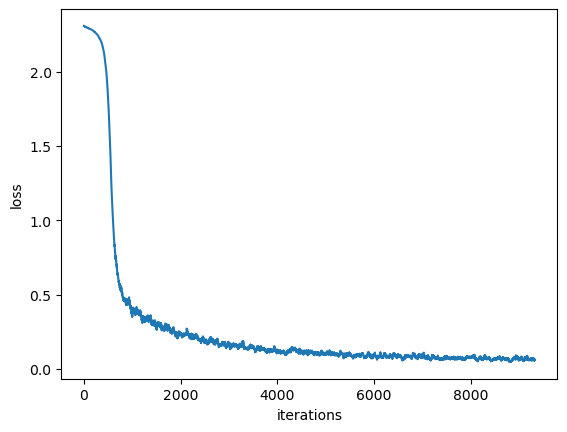

Epoch 5/5, Loss: 0.0678, Accuracy: 0.9794


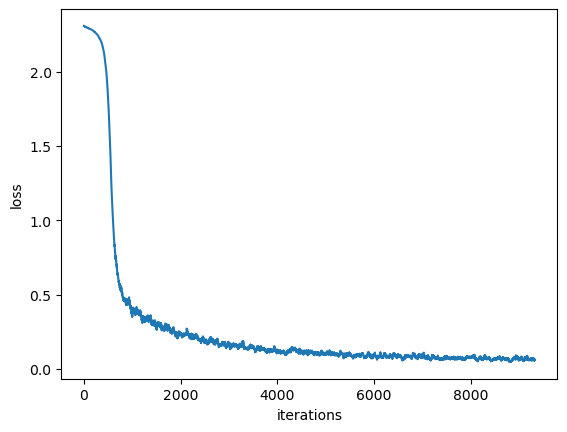

In [8]:
#7 Training Loop
cnn_model.train()
for epoche in range(epoch):
    total_loss = 0
    total_pred = 0
    corrt_pred = 0
    for idx,(image,label) in enumerate (trainloader):
        image = image.to('cuda')
        label = label.to('cuda')

              

        #forwardpass
        output = cnn_model(image)

        #loss 
        total_loss += loss.item() * image.size(0)
        loss = loss_function(output,label)
        loss_value = loss.item()
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        #backward pass
        optimizer.zero_grad()
        loss.backward()

        #update parameters
        optimizer.step()

        #Get Predictions and calculate accuracy
        pred = torch.argmax(output,dim=1)
        corrt_pred += (pred == label).sum().item()
        total_pred += label.size(0) 

    #calculate the accuracy for each epoch
    total_epoc_loss = total_loss / total_pred
    accuracy = corrt_pred / total_pred
    print(f"Epoch {epoche+1}/{epoch}, Loss: {total_epoc_loss:.4f}, Accuracy: {accuracy:.4f}")




In [ ]:
# 8 